In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
from functools import reduce
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [2]:
israel_filenames = ['//Users//edenshrian//Desktop//GDP israel.csv',
                   '//Users//edenshrian//Desktop//Inflation israel.csv',
                   '//Users//edenshrian//Desktop//interest rate israel.csv',
                   '//Users//edenshrian//Desktop//unemployment rate israel.csv']

name_of_variables = ['DATE','GDP','CPI', 'Interest_Rate', 'Unemployment rate']

lag_list = ['Interest_Rate','CPI']

list_of_explains = ['CPI','Interest_Rate','TIME']

In [3]:
plt.rcParams['figure.figsize'] = [16, 9]


class time_series_analysis:
    
    """Helps to understand the time's affect on economic indicators
    Using only Quartely data"""
    
    pass

    def __init__(self):
        
        self.dataframe = 0  
       
    def create_dataframe(self,filenames):
        
        dataframes = []
        for file in filenames:
            df = pd.read_csv(file)
            dataframes.append(df)

        data = reduce(lambda x, y: pd.merge(x, y, on = 'DATE'), dataframes)
        data['DATE'] = pd.to_datetime(data['DATE'])
        data.columns = name_of_variables
        time_periods = []
        for i in range(len(data)):
            i = i+1
            time_periods.append(i)
        data['TIME'] = time_periods

        self.dataframe = data
        
        return self.dataframe  
    
    def correlation(self,df):
        return df.corr()
    
    
    def plot_relation_two_variables(self,df,name_variable_a,name_variable_b):
        
        plt.figure(figsize = [16,9])
        sns.regplot(x = df[name_variable_b], y = df[name_variable_a], fit_reg=True, order = 2);

        return plt.show()

    #Plotting the last X years. 
    def plot_last_X_years(self,df,name_variable_a,name_variable_b,x):

        a = len(df.axes[0]) - x
        df = df[a:]
        fig , ax = plt.subplots(2)
        plt.figure(figsize = [16,9])
        ax[0].plot(df['DATE'],df[name_variable_a]);
        ax[0].set_title(name_variable_a);
        ax[1].plot(df['DATE'],df[name_variable_b]);
        ax[1].set_title(name_variable_b);
        return plt.show()
    
    def plot_yearly_exp_moving_average(self,df,variable_to_plot,num_years):
        df['EMWA- YEARS'] = df[variable_to_plot].ewm(span =4*num_years).mean()
        return df[[variable_to_plot,'EMWA- YEARS']].plot(figsize = (12,8));
    
    def trend_seasonal_plots(self,df,variable_to_plot):
    
        result = seasonal_decompose(df[variable_to_plot],model = 'additive',period = 4)
        fig  = result.plot()
        fig.set_size_inches(14,7)

        return plt.show()
    
    def plot_yearly_rolling_mean_and_std(self,df,variable_to_plot):
    
        df['DATE'] = pd.to_datetime(df['DATE'])
        time_series = df[variable_to_plot]
        time_series.rolling(4).mean().plot(label='4 Quarters Rolling Mean')
        time_series.rolling(4).std().plot(label='4 Quarters Rolling std')
        time_series.plot()
        plt.title(variable_to_plot)
        plt.legend()
        return plt.show()
    

    def simple_linear_regression(self,df,variable_to_predict,explain_variable):

        y = df[variable_to_predict].to_numpy()
        x = df[explain_variable].to_numpy().reshape(-1,1)
        model = LinearRegression().fit(x, y)
        R_squared = model.score(x, y)
        R_squared = np.round(R_squared,3)
        intercept = model.intercept_
        intercept = round(intercept,3)
        coef = model.coef_
        coef = [round(num, 3) for num in coef]
        text1 = 'R squared : {}'.format(R_squared)
        text2 = 'Intercept : {}'.format(intercept)
        text3 = 'Coef : {}'.format(coef)
        X = sm.add_constant(x)
        stats_model = sm.OLS(y,X).fit()

        return text1,text2,text3, print(stats_model.summary())


    
    def multiple_regression(self,df,variable_to_predict,list_of_explain_variables):
        
        y = df[variable_to_predict].to_numpy()
        x_df = df[[variable for variable in list_of_explain_variables]]
        X = x_df.to_numpy()
        model = LinearRegression().fit(X, y)
        R_squared = model.score(X, y)
        R_squared = np.round(R_squared,3)
        intercept = model.intercept_
        intercept = round(intercept,3)
        coef = model.coef_
        coef = [round(num, 3) for num in coef]
        text1 = 'R squared : {}'.format(R_squared)
        text2 = 'Intercept : {}'.format(intercept)
        text3 = 'Coef : {}'.format(coef)
        x = sm.add_constant(X)
        stats_model = sm.OLS(y,x).fit()
        print(stats_model.summary())

        return text1, text2, text3
    

    def adding_previous_variables(self,df,lag_list):
        
        for i in range(len(df.columns)):
            if 'DATE' in df.columns:
                df = df.drop('DATE',axis =1)
            elif 'TIME' in df.columns:
                df = df.drop('TIME',axis =1)
            elif 'EMWA- YEARS' in df.columns:
                df = df.drop('EMWA- YEARS',axis =1)
            elif 'forecast' in df.columns:
                df = df.drop('forecast',axis =1)   
            else :
                df = df
                
        for i in range(len(lag_list)):
                df[lag_list[i] + ' t-1'] = df[lag_list[i]].shift(1)
    
        return df

    def linear_reg_var_in_lag(self,df,variable_to_predict,lag_list):
        
        df = self.adding_previous_variables(df,lag_list)
        df = df.dropna()
        y = df[variable_to_predict].to_list()
        x_df = df.drop([variable_to_predict],axis = 1)
        #x_df = x_df.dropna()
        
        
        list1 = []
        for i in range(len(x_df)):
            i = i +1
            a = x_df.loc[i].to_numpy()
            list1.append(a) 

        X = np.array(list1)
        model = LinearRegression().fit(X, y)
        R_squared = model.score(X, y)
        R_squared = np.round(R_squared,3)
        intercept = model.intercept_
        intercept = round(intercept,3)
        coef = model.coef_
        coef = [round(num, 3) for num in coef]
        text1 = 'R squared : {}'.format(R_squared)
        text2 = 'Intercept : {}'.format(intercept)
        text3 = 'Coef : {}'.format(coef)
        x = sm.add_constant(X)
        stats_model = sm.OLS(y,x).fit()
        
        return text1, text2, text3 , print(stats_model.summary())
    
    def forecast_using_arime(self,df,variable_to_predict):
    
        model = sm.tsa.statespace.SARIMAX(df[variable_to_predict],order=(1, 1, 1),seasonal_order=(1, 1, 1, 4))
        results = model.fit()
        summary = results.summary()
        results.resid.plot()
        plt.title('Residuals of {}'.format(variable_to_predict))
        df['forecast'] = results.predict(start=len(df)-20 , end=len(df))
        df[[variable_to_predict,'forecast']].plot(figsize = (12,8))
        plt.title('Historical and forecast')
        
        self.dataframe = df

        return print(summary)        

In [4]:
analysis = time_series_analysis()

In [5]:
israel = analysis.create_dataframe(israel_filenames)

In [6]:
analysis.correlation(israel)

,GDP,CPI,Interest_Rate,Unemployment rate,TIME
GDP,1.000000,0.936472,-0.875906,-0.759086,0.989327
CPI,0.936472,1.000000,-0.941199,-0.573278,0.963945
Interest_Rate,-0.875906,-0.941199,1.000000,0.477315,-0.925566
Unemployment rate,-0.759086,-0.573278,0.477315,1.000000,-0.713141
TIME,0.989327,0.963945,-0.925566,-0.713141,1.000000


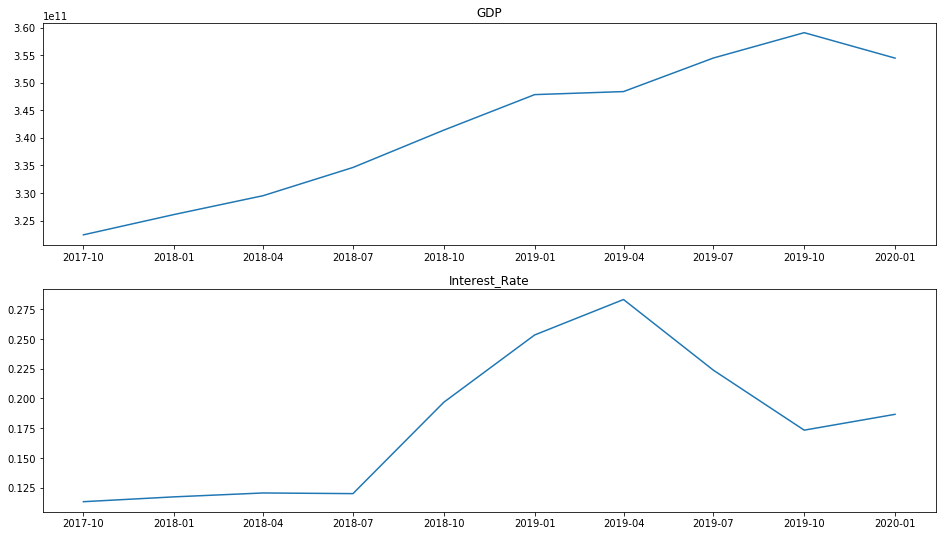

<Figure size 1152x648 with 0 Axes>

In [7]:
analysis.plot_last_X_years(israel,'GDP','Interest_Rate',10)

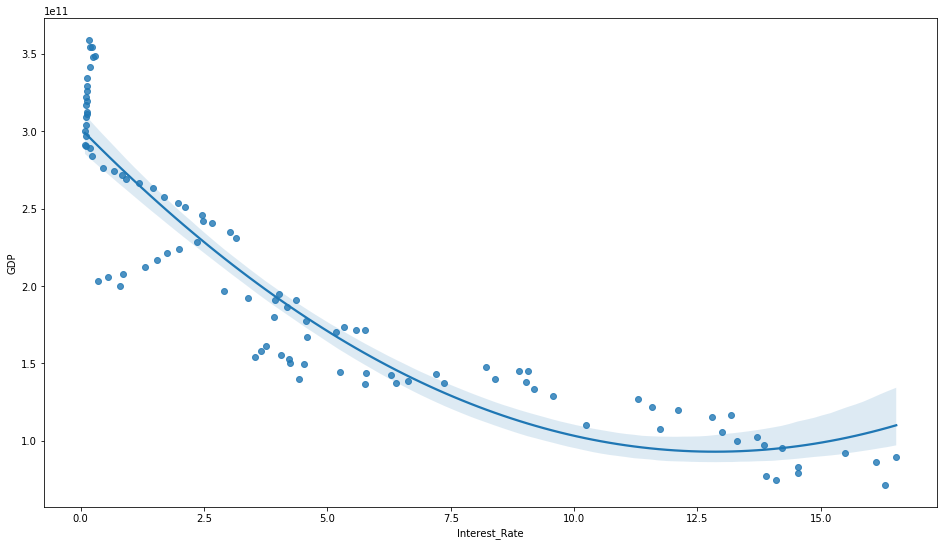

In [8]:
analysis.plot_relation_two_variables(israel,'GDP','Interest_Rate')

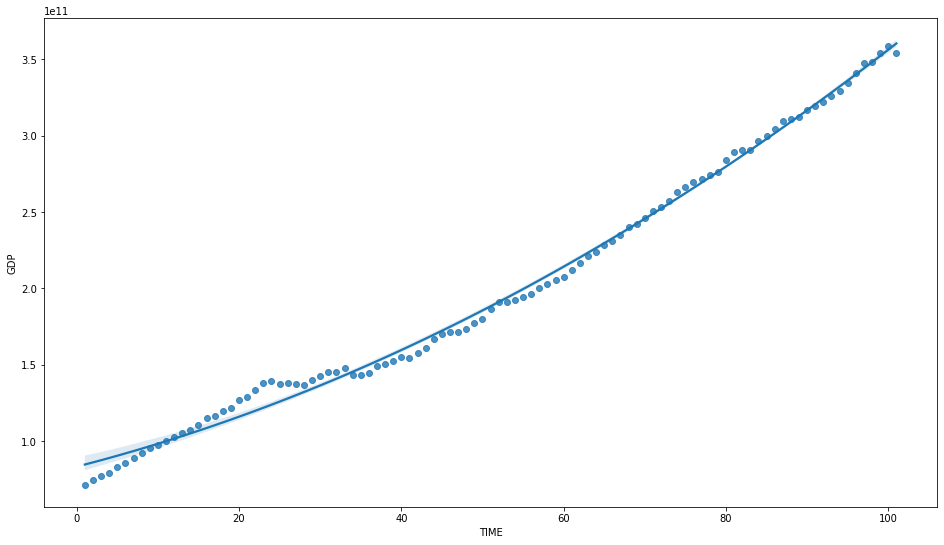

In [9]:
analysis.plot_relation_two_variables(israel,'GDP','TIME')

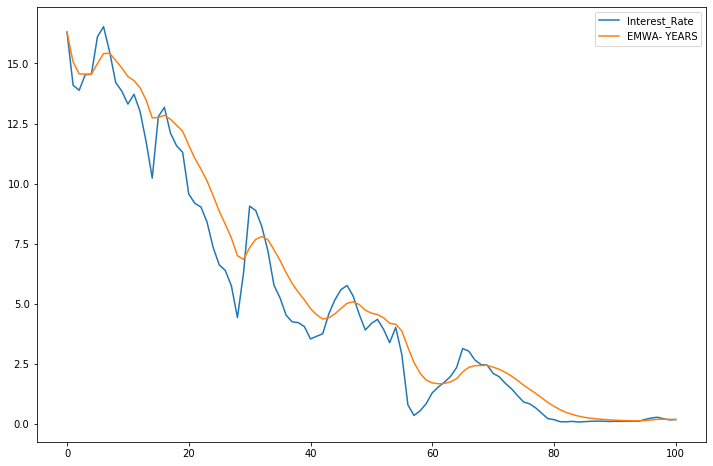

In [11]:
analysis.plot_yearly_exp_moving_average(israel,'Interest_Rate',2)

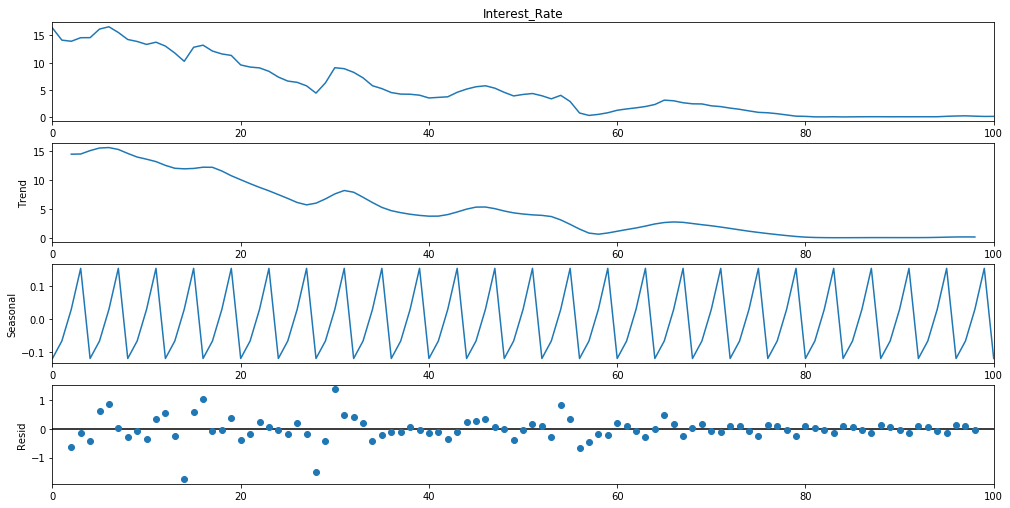

In [12]:
analysis.trend_seasonal_plots(israel,'Interest_Rate')

In [13]:
analysis.simple_linear_regression(israel,'GDP','TIME')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     4564.
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           1.24e-84
Time:                        12:51:11   Log-Likelihood:                -2486.0
No. Observations:                 101   AIC:                             4976.
Df Residuals:                      99   BIC:                             4981.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.936e+10    2.4e+09     24.760      0.0

('R squared : 0.979',
 'Intercept : 59364891805.941',
 'Coef : [2757151947.467]',
 None)

In [14]:
analysis.simple_linear_regression(israel,'GDP','Interest_Rate')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     326.3
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           4.21e-33
Time:                        12:51:20   Log-Likelihood:                -2606.9
No. Observations:                 101   AIC:                             5218.
Df Residuals:                      99   BIC:                             5223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.731e+11   5.65e+09     48.341      0.0

('R squared : 0.767',
 'Intercept : 273128977922.223',
 'Coef : [-14333361585.013]',
 None)

In [15]:
analysis.multiple_regression(israel,'GDP',list_of_explains)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3216.
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           6.26e-97
Time:                        12:51:25   Log-Likelihood:                -2447.7
No. Observations:                 101   AIC:                             4903.
Df Residuals:                      97   BIC:                             4914.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.085e+10   2.14e+10      1.445      0.1

('R squared : 0.99',
 'Intercept : 30852343119.39',
 'Coef : [-410994927.551, 4171119079.663, 3592723600.136]')

In [16]:
analysis.linear_reg_var_in_lag(israel,'GDP',lag_list)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     419.6
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           1.24e-62
Time:                        12:51:28   Log-Likelihood:                -2495.7
No. Observations:                 100   AIC:                             5003.
Df Residuals:                      94   BIC:                             5019.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.175e+10   4.95e+10      0.238      0.8

('R squared : 0.957',
 'Intercept : 11751471169.869',
 'Coef : [-5191768372.484, 1972139463.26, -14170693249.075, -4173820938.482, 8739928100.059]',
 None)

                                     SARIMAX Results                                     
Dep. Variable:                               GDP   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -2221.131
Date:                           Sun, 13 Sep 2020   AIC                           4452.263
Time:                                   12:51:30   BIC                           4465.085
Sample:                                        0   HQIC                          4457.446
                                           - 101                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2825      3.920     -0.072      0.943      -7.966       7.401
ma.L1          0.3047      3.902      0.078

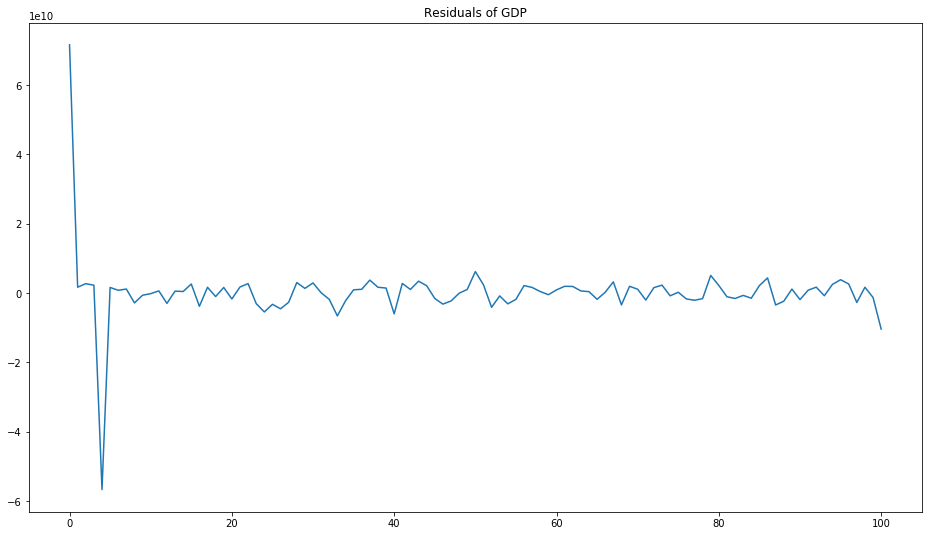

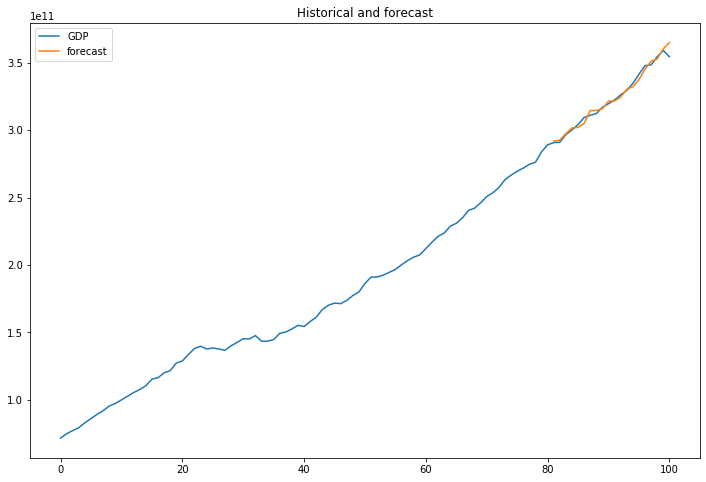

In [17]:
analysis.forecast_using_arime(israel,'GDP')